# Data Science Workbook on LA Traffic

This Jupyter Notebook studies the statistics of traffic accidents recorded in LA. We try to understand the geographic distribution of the acciddnts and the corresponding severity. 

The data is taken from Kaggle: 
https://www.kaggle.com/cityofLA/los-angeles-traffic-collision-data 

Written by Shing Chi Leung 12 October 2021

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import re
import datetime

In [3]:
df = pd.read_csv("traffic-collision-data-from-2010-to-present.csv")

df.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Premise Description,Address,Cross Street,Location,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified)
0,191323054,2019-11-30T00:00:00.000,2019-11-30T00:00:00.000,130,13,Newton,1385,997,TRAFFIC COLLISION,NaN,...,STREET,SAN PEDRO ST,SLAUSON AV,"{'longitude': '-118.2696', 'human_address': '{...",22352.0,786.0,858.0,7.0,13.0,46.0
1,192020666,2019-11-30T00:00:00.000,2019-11-30T00:00:00.000,15,20,Olympic,2054,997,TRAFFIC COLLISION,NaN,...,STREET,OLYMPIC BL,KINGSLEY AV,"{'longitude': '-118.3031', 'human_address': '{...",22723.0,617.0,646.0,NaN,12.0,89.0
2,191616992,2019-11-30T00:00:00.000,2019-11-30T00:00:00.000,230,16,Foothill,1669,997,TRAFFIC COLLISION,NaN,...,STREET,TUJUNGA CANYON BL,LA TUNA CANYON RD,"{'longitude': '-118.2704', 'human_address': '{...",3222.0,5.0,227.0,NaN,1.0,7.0
3,191824082,2019-11-30T00:00:00.000,2019-11-30T00:00:00.000,730,18,Southeast,1802,997,TRAFFIC COLLISION,0605,...,STREET,88TH ST,MAIN ST,"{'longitude': '-118.2739', 'human_address': '{...",22352.0,800.0,358.0,7.0,14.0,45.0
4,191616980,2019-11-30T00:00:00.000,2019-11-30T00:00:00.000,720,16,Foothill,1689,997,TRAFFIC COLLISION,NaN,...,STREET,CROCKETT,SUNLAND,"{'longitude': '-118.3703', 'human_address': '{...",19335.0,166.0,272.0,NaN,3.0,21.0


The dataframe contains a lot of data, some are compatified like the "Location" column which will need further processing. Most of them are readily used. 

Next we briefly look at the dataframe structure. 

In [4]:
df.shape

(502858, 24)

In [19]:
df["Crime Code"].value_counts()

997    502858
Name: Crime Code, dtype: int64

In [83]:
df["Area Name"].value_counts()

77th Street    31806
Southwest      29477
Wilshire       28833
West LA        27223
N Hollywood    26790
Olympic        26674
Pacific        26615
Van Nuys       25457
Newton         25047
Devonshire     24852
Hollywood      24565
West Valley    24419
Northeast      22963
Mission        21965
Topanga        21864
Southeast      20451
Central        20443
Rampart        18959
Harbor         18755
Hollenbeck     18220
Foothill       17480
Name: Area Name, dtype: int64

We can readily see that the districts 77th Street, Southwest and Wilshire are the first three districts with the most frequent traffic accidents. The column "Crime Code" has only one type of input, which is not particularly helpful. 

In doing the data cleaning, we will do the following:

1. Change the column "Date Occurred" into datatime format
2. Extract the longitude and latitude and store the in separate columns


In [70]:
df["Date Occurred"] = pd.to_datetime(df["Date Occurred"])

In [50]:
#re.search(r"\'longitude\': \'(-[0-9.]+)", df.loc[0,"Location"])

def get_longitude(string):
    s = re.search(r"\'longitude\': \'(-[0-9.]+)", string)
    if s:
        return float(s[1])
    else:
        return None

df["longitude"] = df.apply(lambda row: get_longitude(row["Location"]), axis=1)

In [57]:
def get_latitude(string):
    s = re.search(r"\'latitude\': \'([0-9.]+)", string)
    if s:
        return float(s[1])
    else:
        return None

df["latitude"] = df.apply(lambda row: get_latitude(row["Location"]), axis=1)

Now we can extract the range of the data points which are useful for restrict the area of the map we want to study. 

In [61]:
print(df["longitude"].max(), df["longitude"].min())
print(df["latitude"].max(), df["latitude"].min())

-117.7059 -118.6673
34.692 0.0


## Overall of the accident hotspot in 2016 - 2019

Now we filter the data to the latest one year so that we can reduce the sample size. And then we try to find out location with the most traffic accidents. We choosen places to display the frequency by colour and size of marker to identify the danger spots. 

In [164]:
df_filtered = df[df["Date Occurred"] > datetime.datetime(2016,11,30)]
df_filtered.shape

(171027, 27)

In [165]:
df_filtered_grouped = df_filtered.groupby(by=["longitude", "latitude"])
max_case = df_filtered_grouped.size().max()

176

In [169]:
df_filtered_grouped = df_filtered_grouped.filter(lambda group: len(group) > max_case/4)
df_filtered_grouped = df_filtered_grouped.groupby(by=["longitude", "latitude"])

In [170]:
s = df_filtered_grouped.size()

# Get the frequency of each spot
s_freq = s.to_list()

# Extract the corresponding coordinates
s_location = s.index.to_numpy()

s_lon = [l[0] for l in s_location]
s_lat = [l[1] for l in s_location]

With all things prepared, we can now plot the results on the map for visualization and discussion. The map is extracted from https://www.openstreetmap.org/ which allows generation of user-defined map for a given pair of longitudes and latitudes. 

In [80]:
LA_map = plt.imread('map.png')

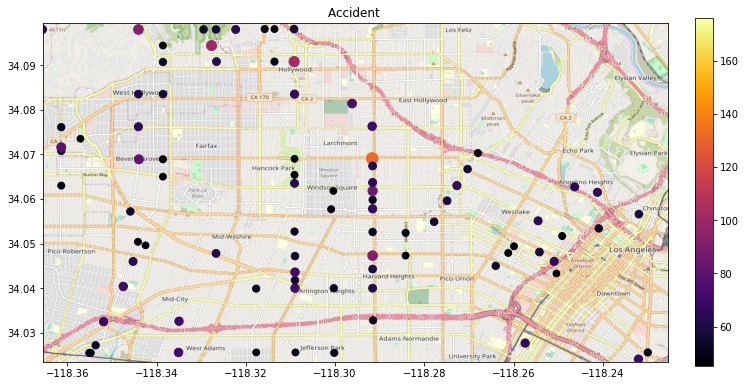

In [176]:
fig, ax = plt.subplots(figsize = (12,11))

cb = ax.scatter(s_lon, s_lat, zorder=1, c=s, s=s, cmap="inferno")

BBox = (-118.3655, -118.2253, 34.0235, 34.0995)

ax.set_title('Accident ')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

plt.colorbar(cb, fraction=0.026, pad=0.04)

ax.imshow(LA_map, zorder=0, extent = BBox, aspect= 'equal')

Now we have an overview to the locations where special attention needed to be paid for the dangerous spots. The dangerous located along Western Ave and near Santa Monica Blvd. 

## Appendix

We can also generate the plot in the whole area but with a more transparent plot to show the global distribution. 

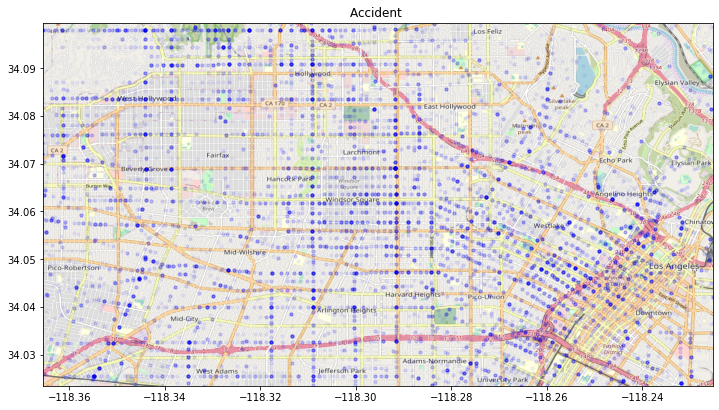

In [129]:
fig, ax = plt.subplots(figsize = (12,11))

ax.scatter(df_filtered.longitude, df_filtered.latitude, zorder=1, alpha= 0.05, c='b', s=10)

BBox = (-118.3655, -118.2253, 34.0235, 34.0995)

ax.set_title('Accident ')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(LA_map, zorder=0, extent = BBox, aspect= 'equal')

When more data is available, we can further classify the type of accidents and the origin so that we can derive better policy for the traffic flow. 